In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import contextily as ctx

import ee

try:
    ee.Authenticate(auth_mode='notebook')
    ee.Initialize(project = 'ee-gsingh')
except: 
    ee.Authenticate()
    ee.Initialize()



In [38]:
pts18 = gpd.read_file(r'C:\Users\coach\myfiles\postdoc\Invasives\aliens_sep2018_bioscape2023.shp')

pts18.loc[pts18['change'] == 0, '2023_class'] = pts18['class']
pts23 = pts18.dropna(subset=['2023_class'])
pts23 = pts23.loc[pts23['2023_class'] != 12]

In [46]:
# https://code.earthengine.google.com/2ecd5164c633d93fa03a72834727cb5f-view protected areas

pas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filter(ee.Filter.eq('NAME','Cape Floral Region Protected Areas'))

# convert to geopandas dataframe
gdfpas = ee.data.computeFeatures({
    'expression': pas,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

gdfpas.crs = 'EPSG:4326'

In [7]:
!jupyter trust Figure 1.ipynb

gdfpas.explore()

[TrustNotebookApp] ERROR | Notebook missing: Figure
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\folium\features.py:1204: UserWarning: GeoJsonTooltip is not configured to render for GeoJson GeometryCollection geometries. Please consider reworking these features: [{'CONS_OBJ': 'Not Applicable', 'DESIG': 'World Heritage Site (natural or mixed)', 'DESIG_ENG': 'World Heritage Site (natural or mixed)', 'DESIG_TYPE': 'International', 'GIS_AREA': 11017.2777374462, 'GIS_M_AREA': 27.1924069187658, 'GOV_TYPE': 'Federal or national ministry or agency', 'INT_CRIT': '(ix)(x)', 'ISO3': 'ZAF', 'IUCN_CAT': 'Not Applicable', 'MANG_AUTH': 'Cape Nature', 'MANG_PLAN': 'Not Reported', 'MARINE': '0', 'METADATAID': 946, 'NAME': 'Cape Floral Region Protected Areas', 'NO_TAKE': 'Not Applicable', 'NO_TK_AREA': 0, 'ORIG_NAME': 'Aires protégées de la Région florale du Cap', 'OWN_TYPE': 'State', 'PARENT_ISO': 'ZAF', 'PA_DEF': '1', 'REP_AREA': 10947.42, 'REP_M_AREA': 0, 'STATUS': 'Inscribed', 'STATUS_YR': 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

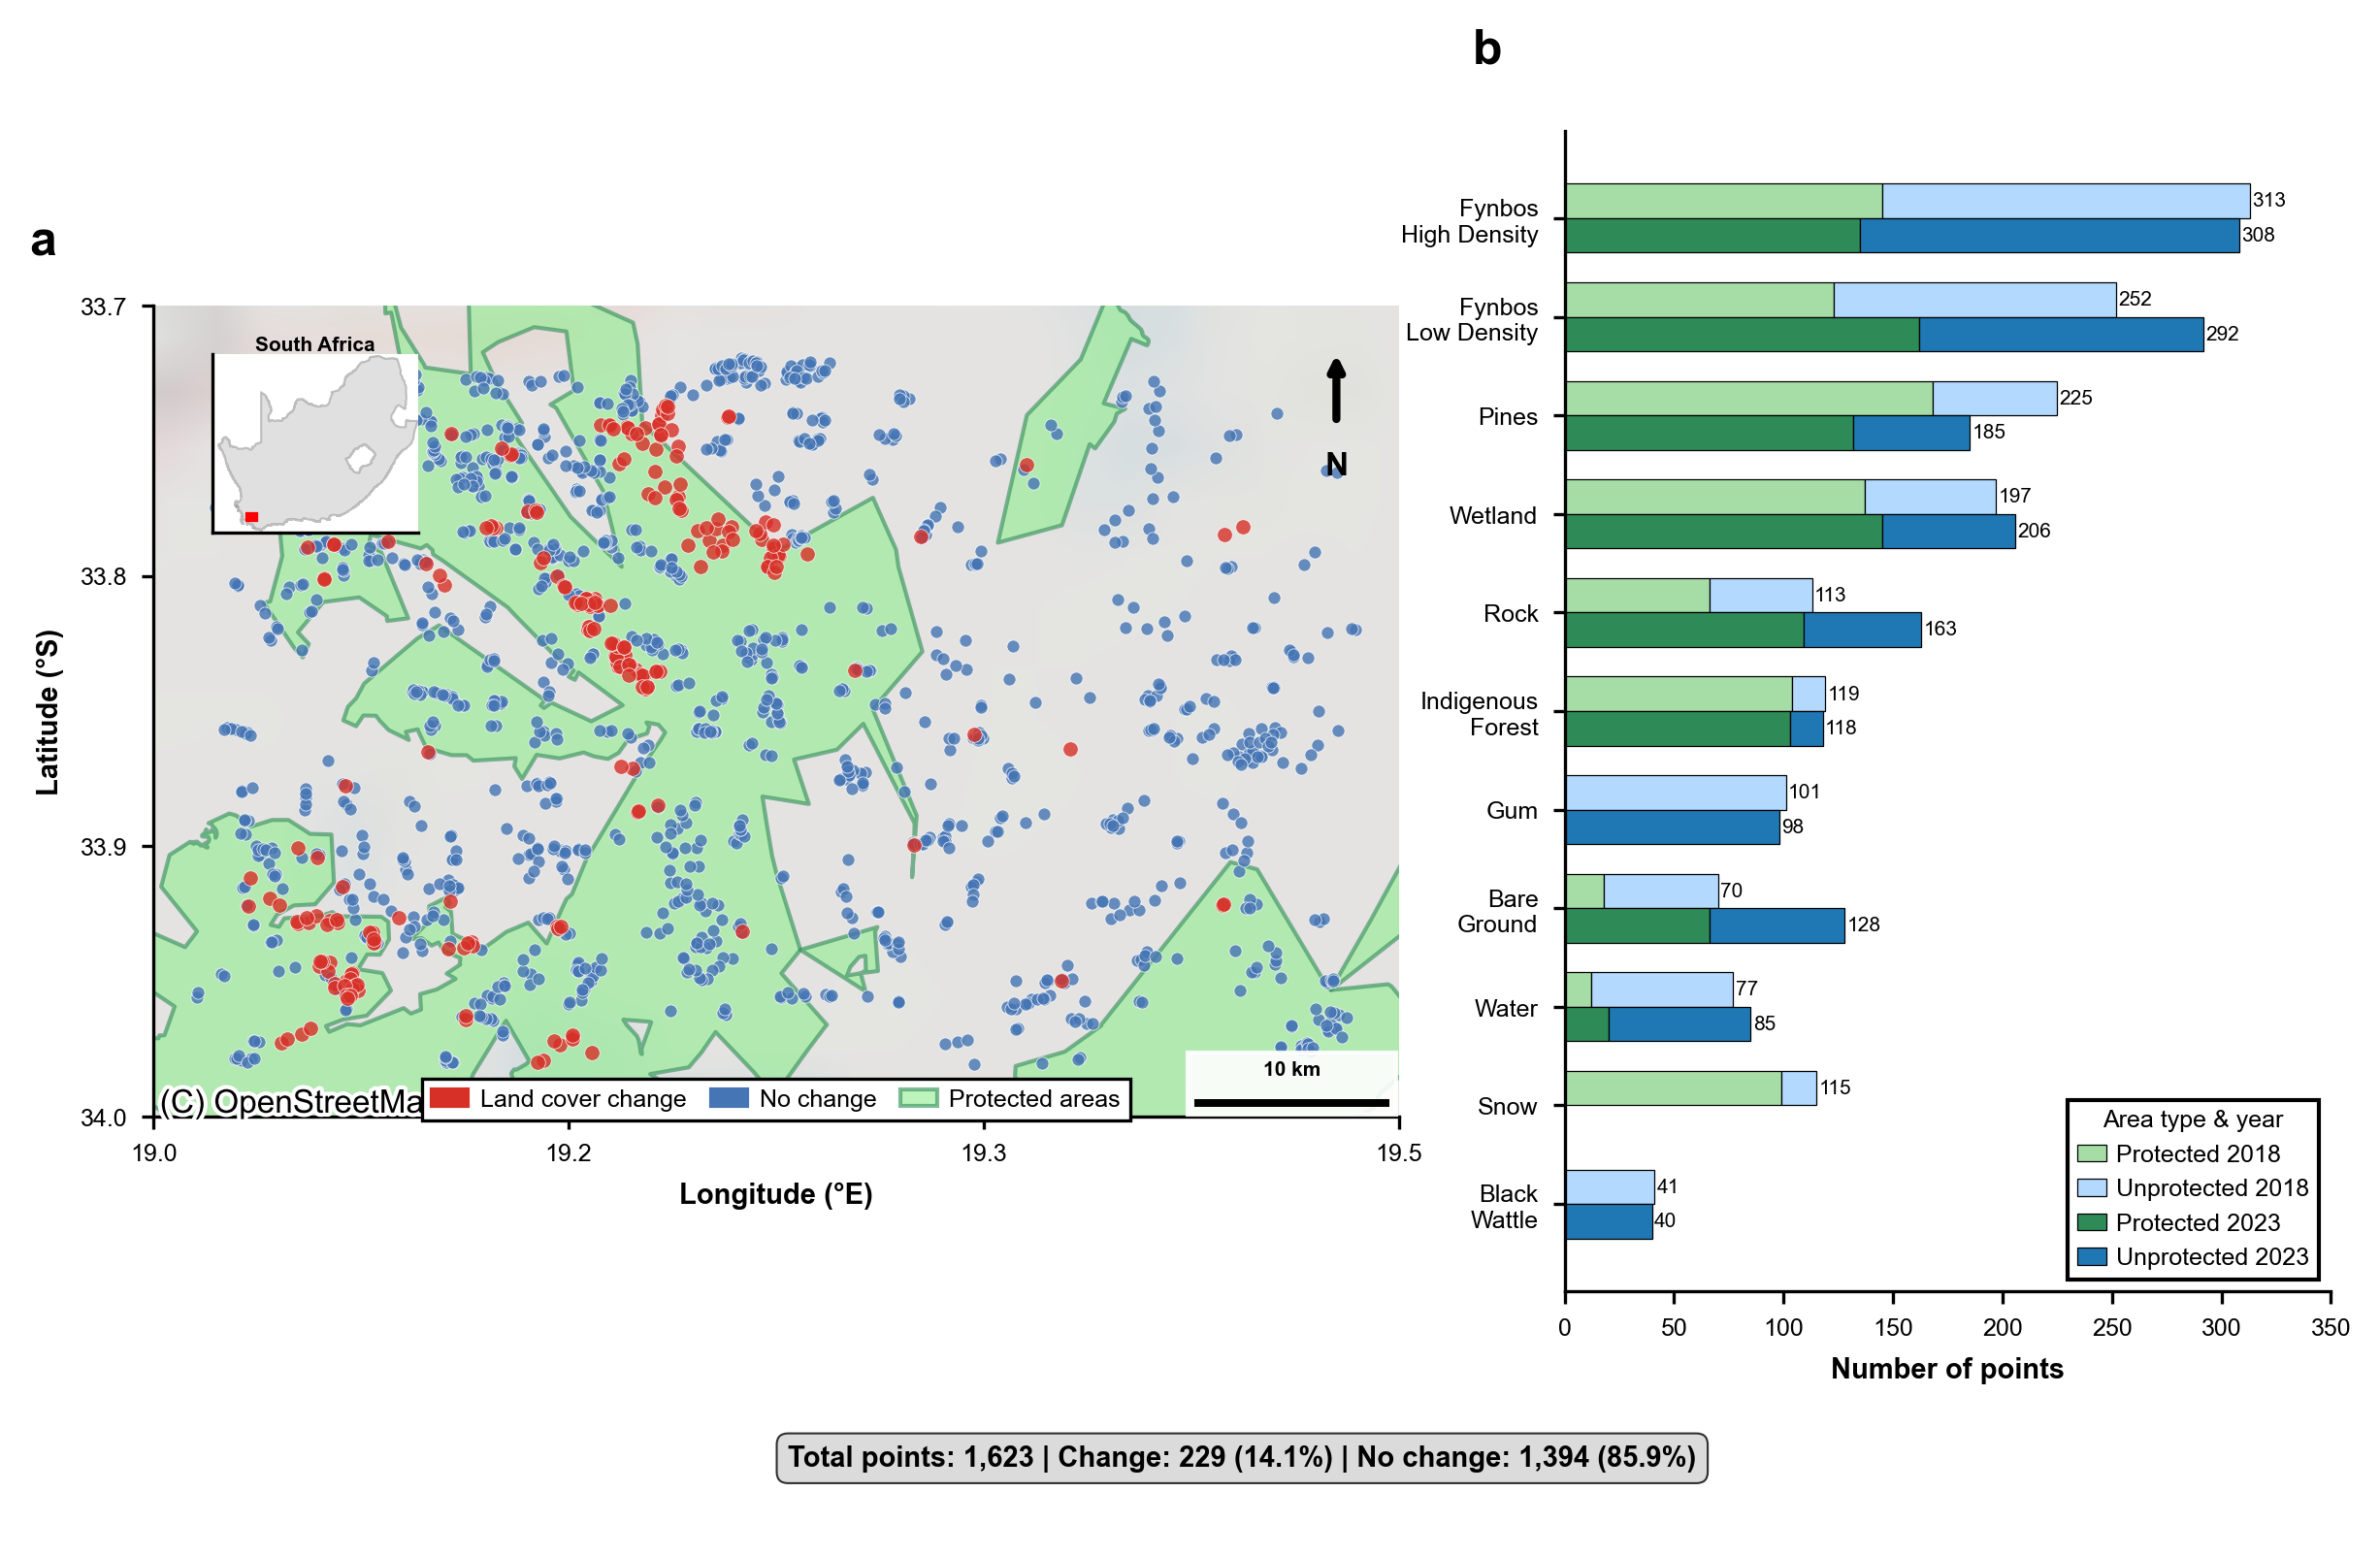

In [ ]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Data sources
POINTS_GDF = pts if 'pts' in globals() else None
PROTECTED_AREAS_GDF = gdfpas if 'gdfpas' in globals() else None
SA_BOUNDARY_PATH = r"C:\Users\coach\myfiles\data\zaf_adm_sadb_ocha_20201109_SHP\zaf_admbnda_adm0_sadb_ocha_20201109.shp"

# Column configurations
CHANGE_COLUMN = "change"
CLASS_2018_COLUMN = "class"
CLASS_2023_COLUMN = "2023_class"

# Class mapping
classDict = {
    "0": "Bare Ground", "1": "Black Wattle", "2": "Pines", 
    "3": "Fynbos High Density", "4": "Fynbos Low Density", "5": "Gum", 
    "6": "Indigenous Forest", "7": "Rock", "8": "Wetland",
    "9": "Snow", "10": "Water"
}

# Styling
CHANGE_COLORS = {'Change': '#D73027', 'No change': '#4575B4'}
BAR_COLORS = ['#4472C4', '#70AD47']
POINT_SIZES = {'No change': 10, 'Change': 14}

def create_sample_data():
    """Generate sample data if real data not available"""
    np.random.seed(42)
    n = 200
    
    # Focus on Cape Town area
    lon = np.random.uniform(18.3, 18.9, n)
    lat = np.random.uniform(-34.4, -33.8, n)
    
    points = gpd.GeoDataFrame({
        CHANGE_COLUMN: np.random.choice([0, 1], n, p=[0.75, 0.25]),
        CLASS_2018_COLUMN: np.random.choice(list(classDict.keys()), n),
        CLASS_2023_COLUMN: np.random.choice(list(classDict.keys()), n),
        'geometry': gpd.points_from_xy(lon, lat)
    }, crs='EPSG:4326')
    
    # Map to descriptive names
    points[CLASS_2018_COLUMN] = points[CLASS_2018_COLUMN].map(classDict)
    points[CLASS_2023_COLUMN] = points[CLASS_2023_COLUMN].map(classDict)
    points['change_label'] = points[CHANGE_COLUMN].map({0: 'No change', 1: 'Change'})
    
    # Sample protected area
    from shapely.geometry import Polygon
    protected = gpd.GeoDataFrame(
        {'id': [1]}, 
        geometry=[Polygon([(18.35, -34.1), (18.55, -34.0), (18.6, -34.3), (18.4, -34.25)])], 
        crs='EPSG:4326')
    
    return points, protected

def create_publication_figure():
    """Create Nature-style publication figure with improved layout"""
    
    # Set Nature-style publication styling
    plt.rcParams.update({
        'font.family': ['Arial', 'Helvetica', 'sans-serif'],
        'font.size': 7,
        'axes.linewidth': 0.8,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 2,
        'ytick.minor.size': 2,
        'xtick.labelsize': 6,
        'ytick.labelsize': 6,
        'legend.frameon': True,
        'legend.framealpha': 1.0,
        'legend.edgecolor': 'black',
        'legend.fancybox': False,
        'legend.fontsize': 6
    })
    
    # Load data
    if POINTS_GDF is not None and PROTECTED_AREAS_GDF is not None:
        points = POINTS_GDF.copy()
        protected = PROTECTED_AREAS_GDF.copy()
        points['change_label'] = points[CHANGE_COLUMN].map({0: 'No change', 1: 'Change'})
    else:
        points, protected = create_sample_data()
    
    # Load South Africa boundary
    try:
        sa_boundary = gpd.read_file(SA_BOUNDARY_PATH).to_crs(points.crs)
    except:
        # Create a simple boundary if file not found
        from shapely.geometry import Polygon
        sa_boundary = gpd.GeoDataFrame(
            {'name': ['South Africa']},
            geometry=[Polygon([
                [16.45, -34.82], [32.83, -34.82], [32.83, -22.22], [16.45, -22.22]
            ])],
            crs='EPSG:4326'
        )
    
    # Calculate extents
    bounds = points.total_bounds
    buffer = 0.02
    extent = [bounds[0]-buffer, bounds[2]+buffer, bounds[1]-buffer, bounds[3]+buffer]
    
    # Prepare stacked bar chart data - Protected Areas vs Total
    # Identify points within protected areas using spatial join
    if len(protected) > 0:
        points_in_protected = gpd.sjoin(points, protected, how='inner', predicate='within')
        protected_2018_counts = points_in_protected[CLASS_2018_COLUMN].value_counts()
        protected_2023_counts = points_in_protected[CLASS_2023_COLUMN].value_counts()
    else:
        protected_2018_counts = pd.Series(dtype=int)
        protected_2023_counts = pd.Series(dtype=int)
    
    # Get total counts
    total_2018_counts = points[CLASS_2018_COLUMN].value_counts()
    total_2023_counts = points[CLASS_2023_COLUMN].value_counts()
    
    # Get top classes based on total occurrence
    all_classes = sorted(set(total_2018_counts.index) | set(total_2023_counts.index), 
                        key=lambda x: total_2018_counts.get(x, 0) + total_2023_counts.get(x, 0), 
                        reverse=True)
    
    # Map class names
    display_classes = []
    for cls in all_classes:
        if str(cls) in classDict:
            display_classes.append(classDict[str(cls)])
        elif cls in classDict.values():
            display_classes.append(cls)
        else:
            display_classes.append(str(cls))
    
    # Create dataframe for stacked bars
    df_counts = pd.DataFrame({
        'Protected_2018': [protected_2018_counts.get(cls, 0) for cls in all_classes],
        'Unprotected_2018': [total_2018_counts.get(cls, 0) - protected_2018_counts.get(cls, 0) for cls in all_classes],
        'Protected_2023': [protected_2023_counts.get(cls, 0) for cls in all_classes],
        'Unprotected_2023': [total_2023_counts.get(cls, 0) - protected_2023_counts.get(cls, 0) for cls in all_classes]
    }, index=display_classes)
    
    # Create figure with Nature-style dimensions (smaller, more compact)
    fig = plt.figure(figsize=(8.5, 6), dpi=300)
    
    # Create compact gridspec with better spacing for panel B
    gs = GridSpec(2, 3, height_ratios=[1, 0.12], width_ratios=[1.3, 0.1, 0.8],
                  hspace=0.15, wspace=0.05, 
                  left=0.08, right=0.96, top=0.92, bottom=0.12)
    
    # Create axes
    ax_map = fig.add_subplot(gs[0, 0])      # Map panel
    ax_bar = fig.add_subplot(gs[0, 2])      # Bar chart panel
    ax_stats = fig.add_subplot(gs[1, :])    # Statistics below everything
    
    # Hide axes for stats
    ax_stats.axis('off')
    
    # Create inset map (top-left corner of main map)
    inset_pos = [0.02, 0.72, 0.22, 0.22]  # Smaller inset
    ax_inset = ax_map.inset_axes(inset_pos)
    
    # === INSET MAP ===
    sa_boundary.plot(ax=ax_inset, color='lightgray', edgecolor='darkgray', alpha=0.7, linewidth=0.5)
    
    # Add study area rectangle
    from matplotlib.patches import Rectangle
    rect = Rectangle((extent[0], extent[2]), extent[1]-extent[0], extent[3]-extent[2],
                    fill=False, edgecolor='red', linewidth=1.5, zorder=10)
    ax_inset.add_patch(rect)
    
    ax_inset.set_xlim(16, 33)
    ax_inset.set_ylim(-35, -22)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_title('South Africa', fontsize=5, fontweight='bold', pad=1)
    
    # Clean inset border
    for spine in ax_inset.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color('black')
    
    # === PANEL A: MAP ===
    # Plot South Africa boundary
    sa_boundary.plot(ax=ax_map, color='lightgray', edgecolor='darkgray', alpha=0.5, linewidth=0.5)
    
    # Plot protected areas
    if len(protected) > 0:
        protected.plot(ax=ax_map, facecolor='lightgreen', edgecolor='#2E8B57', 
                    linewidth=1, alpha=0.6, zorder=2)
    
    # Plot points with refined styling
    for category in ['No change', 'Change']:
        mask = points['change_label'] == category
        if mask.any():
            points[mask].plot(ax=ax_map, color=CHANGE_COLORS[category], 
                            markersize=POINT_SIZES[category], alpha=0.8,
                            edgecolor='white', linewidth=0.2, zorder=3)
    
    # Add basemap
    try:
        ctx.add_basemap(ax=ax_map, crs=points.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.6)
    except:
        pass
    
    # Map formatting
    ax_map.set_xlim(extent[0], extent[1])
    ax_map.set_ylim(extent[2], extent[3])
    ax_map.set_xlabel('Longitude (°E)', fontweight='bold', fontsize=7)
    ax_map.set_ylabel('Latitude (°S)', fontweight='bold', fontsize=7)
    
    # Clean tick formatting
    x_ticks = np.linspace(extent[0], extent[1], 4)
    y_ticks = np.linspace(extent[2], extent[3], 4)
    ax_map.set_xticks(x_ticks)
    ax_map.set_yticks(y_ticks)
    ax_map.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])
    ax_map.set_yticklabels([f'{abs(tick):.1f}' for tick in y_ticks])
    
    # Scale bar - positioned lower right to avoid north arrow
    scalebar = ScaleBar(111319.9, units="m", location='lower right',
                    scale_loc="top", font_properties={'size': 5, 'weight': 'bold'},
                    box_color='white', box_alpha=0.9, pad=0.3)
    ax_map.add_artist(scalebar)
    
    # North arrow - positioned in TOP RIGHT as requested
    ax_map.annotate('', xy=(0.95, 0.95), xytext=(0.95, 0.85),
                    xycoords='axes fraction', ha='center', va='center',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
    ax_map.text(0.95, 0.82, 'N', transform=ax_map.transAxes, 
                fontsize=8, fontweight='bold', ha='center', va='top')
    
    # Panel label
    ax_map.text(-0.1, 1.05, 'a', transform=ax_map.transAxes, 
                fontsize=12, fontweight='bold', va='bottom')
    
    # === LEGEND IN PANEL A (CENTER BOTTOM) ===
    legend_elements = [
        mpatches.Patch(color=CHANGE_COLORS['Change'], label='Land cover change'),
        mpatches.Patch(color=CHANGE_COLORS['No change'], label='No change')
    ]
    if len(protected) > 0:
        legend_elements.append(
            mpatches.Patch(facecolor='lightgreen', edgecolor='#2E8B57', 
                        linewidth=1, alpha=0.6, label='Protected areas'))
    
    # Place legend at bottom center of map panel
    legend = ax_map.legend(handles=legend_elements, loc='lower center', ncol=3, 
                          fontsize=6, framealpha=1.0, columnspacing=1.0,
                          handlelength=1.5, handletextpad=0.5,
                          bbox_to_anchor=(0.5, -0.02))
    legend.get_frame().set_linewidth(0.8)
    
    # === PANEL B: STACKED BAR CHART ===
    y_pos = np.arange(len(all_classes))
    width = 0.35

    # Define color palettes (lighter = 2018, darker = 2023)
    protected_colors = ['#A6DDA6', '#2E8B57']  # light green, dark green
    unprotected_colors = ['#B3D9FF', '#1F78B4']  # light blue, dark blue

    # 2018 stacked bars
    ax_bar.barh(y_pos - width/2, df_counts['Protected_2018'], width,
                color=protected_colors[0], edgecolor='black', linewidth=0.3,
                label='Protected 2018')
    ax_bar.barh(y_pos - width/2, df_counts['Unprotected_2018'], width,
                left=df_counts['Protected_2018'], color=unprotected_colors[0],
                edgecolor='black', linewidth=0.3, label='Unprotected 2018')

    # 2023 stacked bars
    ax_bar.barh(y_pos + width/2, df_counts['Protected_2023'], width,
                color=protected_colors[1], edgecolor='black', linewidth=0.3,
                label='Protected 2023')
    ax_bar.barh(y_pos + width/2, df_counts['Unprotected_2023'], width,
                left=df_counts['Protected_2023'], color=unprotected_colors[1],
                edgecolor='black', linewidth=0.3, label='Unprotected 2023')

    # Add value labels
    for i, (p18, u18, p23, u23) in enumerate(zip(df_counts['Protected_2018'],
                                                 df_counts['Unprotected_2018'],
                                                 df_counts['Protected_2023'],
                                                 df_counts['Unprotected_2023'])):
        total_2018 = p18 + u18
        total_2023 = p23 + u23
        if total_2018 > 0:
            ax_bar.text(total_2018 + 1, y_pos[i] - width/2, f'{total_2018}',
                        va='center', ha='left', fontsize=5)
        if total_2023 > 0:
            ax_bar.text(total_2023 + 1, y_pos[i] + width/2, f'{total_2023}',
                        va='center', ha='left', fontsize=5)

    # Prepare compact class labels
    class_labels = []
    for cls in df_counts.index:
        cls_str = str(cls)
        if len(cls_str) > 10:
            if ' ' in cls_str:
                words = cls_str.split()
                if len(words) == 2:
                    class_labels.append(f'{words[0]}\n{words[1]}')
                else:
                    mid = len(words) // 2
                    class_labels.append('\n'.join([' '.join(words[:mid]), ' '.join(words[mid:])]))
            else:
                class_labels.append(cls_str)
        else:
            class_labels.append(cls_str)

    # Axes formatting
    ax_bar.set_xlabel('Number of points', fontweight='bold', fontsize=7)
    # ax_bar.set_ylabel('Land cover class', fontweight='bold', fontsize=7)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(class_labels, fontsize=6)
    ax_bar.invert_yaxis()
    ax_bar.set_xlim(0, 350)

    # Legend
    ax_bar.legend(ncol=1, fontsize=6, frameon=True, loc='lower right',
                  title="Area type & year", title_fontsize=6,
                  columnspacing=0.8, handlelength=1.2, handletextpad=0.4)

    # Panel label
    ax_bar.text(-0.12, 1.05, 'b', transform=ax_bar.transAxes,
                fontsize=12, fontweight='bold', va='bottom')


    
    # === SUMMARY STATISTICS (COMPACT) ===
    total_points = len(points)
    change_points = len(points[points['change_label'] == 'Change'])
    no_change_points = len(points[points['change_label'] == 'No change'])
    change_percent = (change_points / total_points) * 100
    
    summary_text = f"Total points: {total_points:,} | " \
                  f"Change: {change_points:,} ({change_percent:.1f}%) | " \
                  f"No change: {no_change_points:,} ({100-change_percent:.1f}%)"
    
    ax_stats.text(0.5, 0.5, summary_text, transform=ax_stats.transAxes,
                 ha='center', va='center', fontsize=7, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray", 
                          alpha=0.8, edgecolor='black', linewidth=0.5))
    
    return fig

def main(points_gdf=None, protected_areas_gdf=None):
    """Main function"""
    global POINTS_GDF, PROTECTED_AREAS_GDF
    if points_gdf is not None:
        POINTS_GDF = points_gdf
    if protected_areas_gdf is not None:
        PROTECTED_AREAS_GDF = protected_areas_gdf
    
    fig = create_publication_figure()
    plt.show()
    return fig

if __name__ == "__main__":
    main()

### LUCAS map

In [33]:
def create_lucas_figure(points):
    """Create figure for LUCAS points (2015 vs 2018) without protected areas"""
    
    # Add change labels if not already present
    if "change_label" not in points.columns:
        points['change_label'] = points[CHANGE_COLUMN].map({0: 'No change', 1: 'Change'})
    
    # Load South Africa boundary
    # sa_boundary = gpd.read_file(SA_BOUNDARY_PATH).to_crs(points.crs)
    
    # Extent
    bounds = points.total_bounds
    buffer = 1.5
    extent = [bounds[0]-buffer, bounds[2]+buffer, bounds[1]-buffer, bounds[3]+buffer]
    
    # Counts for bar chart
    counts_2015 = points[CLASS_2015_COLUMN].value_counts()
    counts_2018 = points[CLASS_2018_COLUMN].value_counts()
    
    all_classes = sorted(
        set(counts_2015.index) | set(counts_2018.index),
        key=lambda x: counts_2015.get(x, 0) + counts_2018.get(x, 0),
        reverse=True
    )
    
    df_counts = pd.DataFrame({
        '2015': [counts_2015.get(cls, 0) for cls in all_classes],
        '2018': [counts_2018.get(cls, 0) for cls in all_classes]
    }, index=all_classes)
    
    # --- FIGURE LAYOUT ---
    fig = plt.figure(figsize=(7.5, 5.5), dpi=300)
    gs = GridSpec(2, 3, height_ratios=[1, 0.12], width_ratios=[1.2, 0.1, 0.8],
                  hspace=0.15, wspace=0.05, 
                  left=0.08, right=0.96, top=0.92, bottom=0.12)
    
    ax_map = fig.add_subplot(gs[0, 0])
    ax_bar = fig.add_subplot(gs[0, 2])
    ax_stats = fig.add_subplot(gs[1, :])
    ax_stats.axis("off")
    
    # --- PANEL A: MAP ---
    # sa_boundary.plot(ax=ax_map, color="lightgray", edgecolor="darkgray", alpha=0.5)
    
    for category in ["No change", "Change"]:
        mask = points["change_label"] == category
        if mask.any():
            points[mask].plot(ax=ax_map, color=CHANGE_COLORS[category],
                              markersize=POINT_SIZES[category], alpha=0.8,
                              edgecolor="white", linewidth=0.2)
    
    ctx.add_basemap(ax_map, crs=points.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.6)
    ax_map.set_xlim(extent[0], extent[1])
    ax_map.set_ylim(extent[2], extent[3])
    ax_map.set_xlabel("Longitude (°E)", fontsize=7, fontweight="bold")
    ax_map.set_ylabel("Latitude (°S)", fontsize=7, fontweight="bold")
    
    legend = ax_map.legend(
        handles=[
            mpatches.Patch(color=CHANGE_COLORS['Change'], label='Land cover change'),
            mpatches.Patch(color=CHANGE_COLORS['No change'], label='No change')
        ],
        loc="lower center", ncol=2, fontsize=6, frameon=True,
        bbox_to_anchor=(0.5, -0.02)
    )
    legend.get_frame().set_linewidth(0.8)
    
    ax_map.text(-0.1, 1.05, "a", transform=ax_map.transAxes, fontsize=12, fontweight="bold")
    
    # --- PANEL B: BAR CHART ---
    y_pos = np.arange(len(all_classes))
    width = 0.35
    
    ax_bar.barh(y_pos - width/2, df_counts["2015"], height=width,
                color= BAR_COLORS[0], edgecolor="black", linewidth=0.3, label="2015")
    ax_bar.barh(y_pos + width/2, df_counts["2018"], height=width,
                color= BAR_COLORS[1], edgecolor="black", linewidth=0.3, label="2018")
    
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(df_counts.index, fontsize=6)
    ax_bar.invert_yaxis()
    ax_bar.set_xlabel("Number of points", fontsize=7, fontweight="bold")
    ax_bar.legend(fontsize=6, frameon=True, loc="lower right")
    
    ax_bar.text(-0.12, 1.05, "b", transform=ax_bar.transAxes,
                fontsize=12, fontweight="bold", va="bottom")
    
    # --- PANEL C: SUMMARY ---
    total_points = len(points)
    change_points = len(points[points["change_label"] == "Change"])
    change_percent = (change_points / total_points) * 100
    no_change_points = len(points[points["change_label"] == "No change"])
    
    summary = f"Total points: {total_points:,} | " \
                  f"Change: {change_points:,} ({change_percent:.1f}%) | " \
                  f"No change: {no_change_points:,} ({100-change_percent:.1f}%)"
    ax_stats.text(0.5, 0.5, summary, ha="center", va="center",
                  fontsize=7, fontweight="bold",
                  bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray",
                            edgecolor="black", linewidth=0.5, alpha=0.8))
    
    return fig


In [28]:
# Load 2015 and 2018 LUCAS datasets
lucas_2015 = gpd.read_file(
    r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2015_V2.geojson"
)
lucas_2018 = gpd.read_file(
    r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2018.geojson"
)

# Check common keys
print(lucas_2015.columns)
print(lucas_2018.columns)

# Merge on `point_id`
lucas_merged = lucas_2015.merge(
    lucas_2018[["point_id", "class"]],  # only keep ID + class from 2018
    on="point_id",
    suffixes=("_2015", "_2018")
)

# Ensure CRS is consistent
lucas_merged = lucas_merged.set_crs(lucas_2015.crs)

# Rename columns for clarity
lucas_merged = lucas_merged.rename(
    columns={"class_2015": "class2015", "class_2018": "class2018"}
)

print(lucas_merged.head())


Index(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'change',
       'cluster', 'point_id', 'class', 'class_enc', 'source', 'geometry'],
      dtype='object')
Index(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'change',
       'cluster', 'point_id', 'class', 'class_enc', 'source', 'ccd_change',
       'geometry'],
      dtype='object')
      SR_B2     SR_B3     SR_B4     SR_B5     SR_B6     SR_B7  change  \
0  0.969204  0.923196  0.937318  0.940865  0.455930  0.355046       0   
1  0.086151  0.122149  0.157362  0.301023  0.323628  0.232740       0   
2  0.082782  0.122052  0.153320  0.283560  0.299538  0.211730       0   
3  0.122300  0.168967  0.202875  0.348075  0.303415  0.226690       0   
4  0.157335  0.209791  0.247535  0.326721  0.341282  0.263059       0   

   cluster  point_id        class2015  class_enc source  \
0        4  35423440        Grassland          3   2015   
1        0  47261442         Cropland          2   2015   
2        0  47341436       

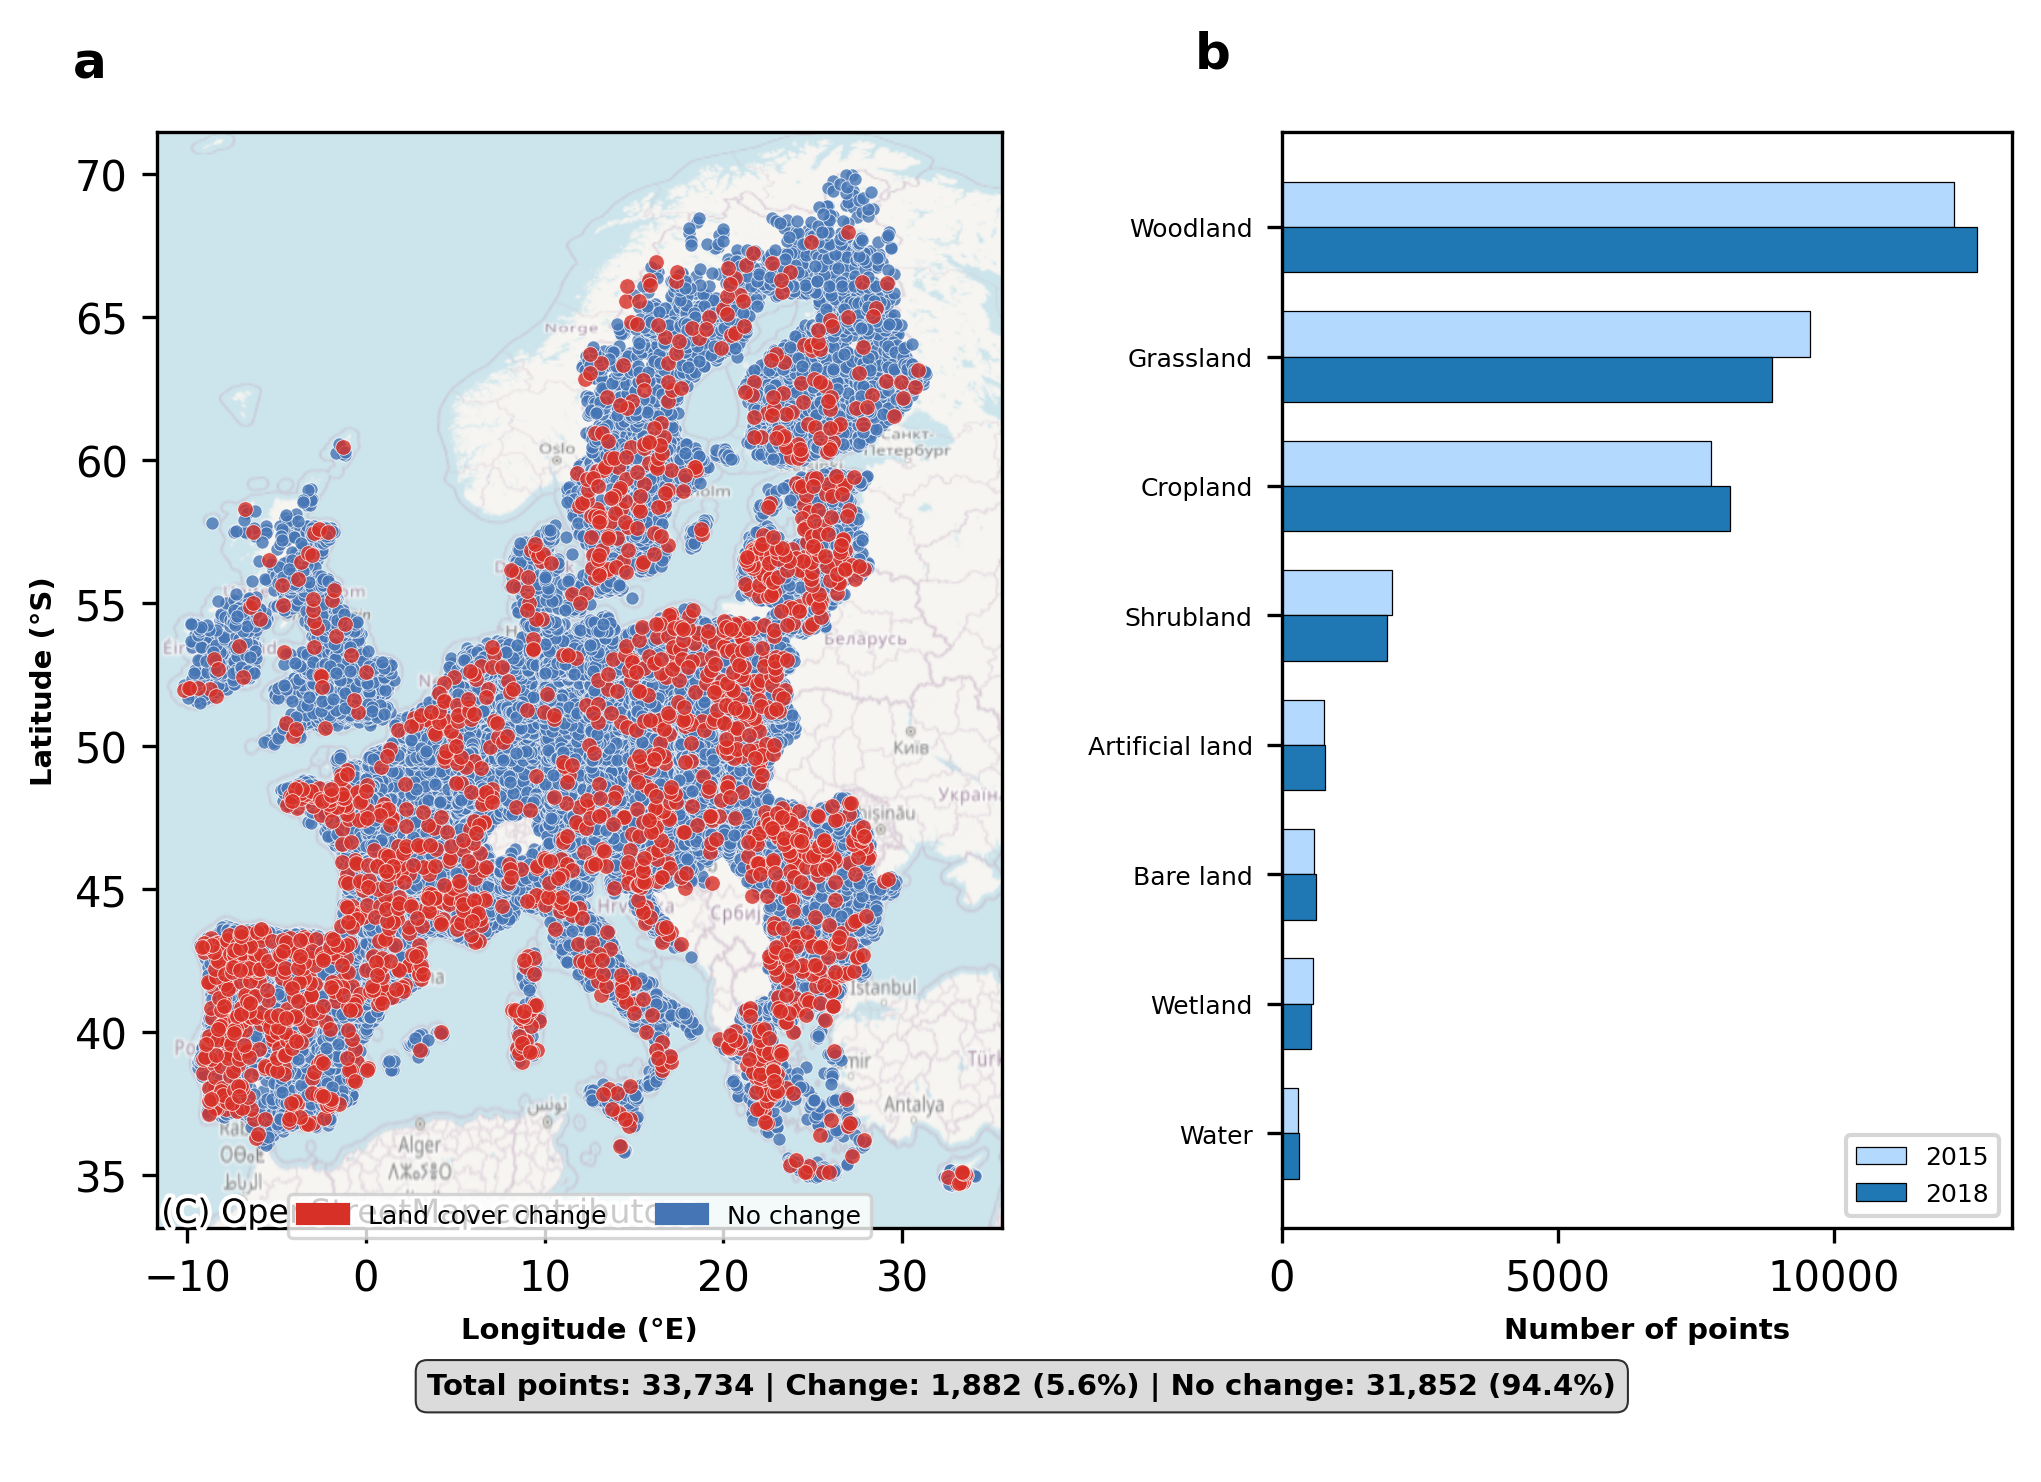

In [34]:
CHANGE_COLUMN = "change"
CLASS_2018_COLUMN = "class2018"
CLASS_2015_COLUMN = "class2015"

CHANGE_COLORS = {'Change': '#D73027', 'No change': '#4575B4'}
BAR_COLORS = ['#B3D9FF', '#1F78B4']  # light blue, dark blue
POINT_SIZES = {'No change': 10, 'Change': 14}

fig = create_lucas_figure(lucas_merged)
plt.show()


### Figure 3: Prediction comparison

In [1]:
import ee
try:
    ee.Authenticate(auth_mode='notebook')
    ee.Initialize(project = 'ee-gsingh')
except: 
    ee.Authenticate()
    ee.Initialize()
import xarray as xr

In [ ]:
! uv pip install xee -U

In [2]:
import xee
from geeml.utils import eeprint
import matplotlib.pyplot as plt
import numpy as np

In [41]:
# IAS case study
# define aoi
# load sentinel data
# run inference
# save outputs (google earth image, sentinel image, prediction map (MS, HS) wessels, experiment 5, gold standard)

In [3]:
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/postdoc/aliens_sep2018_bioscape2023')
eeprint(pts.limit(5))
aoi = pts.geometry().bounds()

In [4]:
sampleAreas = ee.FeatureCollection.randomPoints(aoi, 3, 42, 10).map(lambda pt: pt.buffer(2560).bounds()).first()
sampleAreas

In [5]:
def createComposite(imageCollection: str, points: ee.Geometry, year: int, period:str):
    """Creates a composite image of a point over a given year (uses 1 month period for 2018 and 2 months for 2023).
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
        period (str): Either values of first (Sept-09), second(oct-Nov) or both. 
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    if period == 'first':
        startDate = f'{year}-09-01'
        endDate = f'{year}-10-01'
    elif period == 'second':
        startDate = f'{year}-10-22'
        endDate = f'{year}-11-27'
        # startDate = f'{year}-10-01'
        # endDate = f'{year}-12-01'
        

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(points).linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000)

In [6]:
# ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

composite2018 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2018,
                period='first')

# Create a composite for 2023
composite2023 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2023,
                period='second')

In [7]:
import geemap

Map = geemap.Map()
Map.centerObject(sampleAreas.geometry(), 11)
Map.add_basemap('SATELLITE')
Map.addLayer(aoi, {}, 'AOI', True)
sampleAreas = ee.FeatureCollection.randomPoints(aoi, 3, 42, 50).map(lambda pt: pt.buffer(2560).bounds())
# sampleAreas
Map.addLayer(sampleAreas, {}, 'Sample Area', True)
Map.addLayer(ee.Feature(sampleAreas.toList(3).get(0)).geometry(), {}, 'Selected area', True)

# Map.addLayer(composite2018, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 2018', False)
# Map.addLayer(composite2023, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 2023', False)
Map

Map(center=[-33.805968481953194, 19.167364059685983], controls=(WidgetControl(options=['position', 'transparen…

In [8]:
wavelength23_cols = ['B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']
ds = xr.open_dataset(composite2018.select(wavelength23_cols),
                    engine = 'ee',
                    crs = 'EPSG:4326',
                    scale = 0.0001,
                    geometry = ee.Feature(sampleAreas.toList(3).get(0)).geometry())
ds

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 1, lon: 552, lat: 461)
Coordinates:
  * time     (time) int64 8B 0
  * lon      (lon) float64 4kB 19.34 19.34 19.34 19.34 ... 19.39 19.39 19.39
  * lat      (lat) float64 4kB -33.94 -33.94 -33.94 ... -33.89 -33.89 -33.89
Data variables:
    B2       (time, lon, lat) float32 1MB ...
    B3       (time, lon, lat) float32 1MB ...
    B4       (time, lon, lat) float32 1MB ...
    B5       (time, lon, lat) float32 1MB ...
    B6       (time, lon, lat) float32 1MB ...
    B7       (time, lon, lat) float32 1MB ...
    B8       (time, lon, lat) float32 1MB ...
    B11      (time, lon, lat) float32 1MB ...
    B12      (time, lon, lat) float32 1MB ...
Attributes:
    crs:      EPSG:4326

In [9]:
ds.rio.write_crs('EPSG:4326')
ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
# ds.rio.write_cordinate_system(inplace=True)

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 1, lon: 552, lat: 461)
Coordinates:
  * time     (time) int64 8B 0
  * lon      (lon) float64 4kB 19.34 19.34 19.34 19.34 ... 19.39 19.39 19.39
  * lat      (lat) float64 4kB -33.94 -33.94 -33.94 ... -33.89 -33.89 -33.89
Data variables:
    B2       (time, lon, lat) float32 1MB ...
    B3       (time, lon, lat) float32 1MB ...
    B4       (time, lon, lat) float32 1MB ...
    B5       (time, lon, lat) float32 1MB ...
    B6       (time, lon, lat) float32 1MB ...
    B7       (time, lon, lat) float32 1MB ...
    B8       (time, lon, lat) float32 1MB ...
    B11      (time, lon, lat) float32 1MB ...
    B12      (time, lon, lat) float32 1MB ...
Attributes:
    crs:      EPSG:4326

In [10]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import reshape_as_image
from tqdm.auto import tqdm
from pathlib import Path
import concurrent.futures
import threading
import logging
import warnings
import os

warnings.filterwarnings("ignore")

def inference_xds(ds, confModel, outfile: str, patchSize: int, num_workers: int = 4):
    """
    Run inference on an xarray.Dataset loaded with xee, using a trained model.

    Args:
        ds (xarray.Dataset): Input dataset (already opened with engine="ee").
        confModel: Trained model (e.g. MAPIE classifier).
        outfile (str): Path to save output GeoTIFF.
        patchSize (int): Patch size to process in parallel.
        num_workers (int): Number of parallel workers.

    Returns:
        GeoTIFF with classification result.
    """
    # Drop or squeeze time dimension if present
    if "time" in ds.dims:
        ds = ds.isel(time=0).drop("time")
        
    # Make sure spatial dims are named correctly
    ds_renamed = ds.rename({"lat": "y", "lon": "x"}) if "lat" in ds.dims else ds

    # Convert to stacked DataArray with dims (y, x, bands)
    da = ds_renamed.to_array().transpose("y", "x", "variable")
    
    # Get coordinate arrays
    x_coords = ds.coords["lon"].values
    y_coords = ds.coords["lat"].values
    
    # Sort coordinates to ensure proper orientation
    x_coords = np.sort(x_coords)  # West to East
    y_coords = np.sort(y_coords)[::-1]  # North to South (reversed for array indexing)
    
    # Reindex the DataArray to match sorted coordinates
    da = da.reindex(x=x_coords, y=y_coords)
    i_arr = da.values.astype(np.float32)   # (rows, cols, bands)

    nRows, nCols, nBands = i_arr.shape
    bandnames = list(ds_renamed.data_vars)

    # Calculate resolution (should be positive for x, negative for y in geographic coords)
    xres = float(x_coords[1] - x_coords[0])
    yres = float(y_coords[0] - y_coords[1])  # This will be positive since y_coords is reversed
    
    # Create transform with proper orientation
    # Upper-left corner coordinates
    transform = from_origin(x_coords.min(), y_coords.max(), xres, yres)
    
    profile = {
        "driver": "GTiff",
        "height": nRows,
        "width": nCols,
        "count": 1,
        "dtype": "float64",
        "crs": ds.rio.crs if hasattr(ds, "rio") else ds.attrs.get("crs", "EPSG:4326"),
        "transform": transform,
        "tiled": True,
        "blockxsize": patchSize,
        "blockysize": patchSize
    }

    logger = logging.getLogger(__name__)

    with rasterio.open(Path(outfile), "w", **profile) as dst:
        windows = [window for ij, window in dst.block_windows()]

        read_lock = threading.Lock()
        write_lock = threading.Lock()

        def process(window):
            row_off, col_off = window.row_off, window.col_off
            num_rows, num_cols = window.height, window.width

            with read_lock:
                subarr = i_arr[row_off:row_off+num_rows, col_off:col_off+num_cols, :]
                nPixels = num_rows * num_cols
                new_arr = subarr.reshape(nPixels, nBands)
                data = pd.DataFrame(new_arr, columns=bandnames).fillna(0)

                y_pred = confModel.predict(data)
                result = y_pred.reshape([num_rows, num_cols]).astype(np.float64)

            with write_lock:
                dst.write(result, window=window, indexes=1)
                dst.set_band_description(1, "classification")

        with tqdm(total=len(windows), desc=os.path.basename(outfile)) as pbar:
            with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                futures = {executor.submit(process, window): window for window in windows}
                try:
                    for future in concurrent.futures.as_completed(futures):
                        future.result()
                        pbar.update(1)
                except Exception as ex:
                    logger.info("Cancelling...")
                    executor.shutdown(wait=False, cancel_futures=True)
                    raise ex

    print(f"Saved classified GeoTIFF to {outfile}")
    return outfile

In [70]:
import joblib
out_path = r'C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\figures\classification_sample.tif'
model_path = r"C:\Users\coach\myfiles\postdoc\Invasives\models\random_forest.pkl"   # choose any path you like
# -------------------------------------------------
# 3. Import the model when you need it again
# ------------------------------------------------- # same path you used when saving
loaded_clf = joblib.load(model_path)

inference_xds(
    ds=ds,
    confModel=loaded_clf,
    outfile=out_path,
    patchSize=256,
    num_workers=4
)

classification_sample.tif:   0%|          | 0/6 [00:00<?, ?it/s]

Saved classified GeoTIFF to C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\figures\classification_sample.tif


'C:\\Users\\coach\\myfiles\\postdoc\\Invasives\\data\\Invasie species\\figures\\classification_sample.tif'

In [1]:
! uv pip install rioxarray -U

Using Python 3.12.7 environment at C:\ProgramData\Anaconda3\envs\erthy
Resolved 19 packages in 418ms
Prepared 1 package in 48ms
Uninstalled 1 package in 20ms
Installed 1 package in 25ms
 - rioxarray==0.17.0
 + rioxarray==0.19.0


In [75]:
!jupyter trust ./Figure_1.ipynb

Signing notebook: ./Figure_1.ipynb


C:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\nbformat\__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [10]:
# convert to geopandas dataframe
gdf = ee.data.computeFeatures({
    'expression': sampleAreas,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

gdf.crs = 'EPSG:4326'
gdf.explore()

In [17]:
# --------------------------------------------------------------
# Figure_1_publication_style.py – Map with styled lat/long axes
# --------------------------------------------------------------
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np

# Apply Nature-style settings
plt.rcParams.update({
    'font.family': ['Arial', 'Helvetica', 'sans-serif'],
    'font.size': 7,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6
})

# Example: load your data (already in 3857)
gdf = gdf.iloc[:1].to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)

ctx.add_basemap(ax,
                source=ctx.providers.Esri.WorldImagery,
                crs=gdf.crs,
                zoom=14,
                alpha=0.9)

# Transformer
transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

# Choose reduced tick positions (3–4 per axis)
x_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3)
y_ticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 3)

# Convert to lon/lat
lon_ticks, _ = transformer.transform(x_ticks, np.zeros_like(x_ticks))
_, lat_ticks = transformer.transform(np.zeros_like(y_ticks), y_ticks)

# Apply ticks with one decimal
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels([f"{lon:.2f}" for lon in lon_ticks])
ax.set_yticklabels([f"{abs(lat):.2f}" for lat in lat_ticks])

# Axis labels with cardinality
ax.set_xlabel("Longitude (°E)", fontweight="bold", fontsize=7)
ax.set_ylabel("Latitude (°S)", fontweight="bold", fontsize=7)

# Save
plt.savefig(
    r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\figures\satellite_image_pub.png",
    dpi=300, bbox_inches="tight"
)
plt.close()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 